In [1]:
from Learning import *
from Graphing import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Test model function
# If rc true, perform regression instead and label based on the regression prediction
def test_model(data_tup, subj_dep=True, emos=emo_labels_all, fade_in_buffer=0,
               rc=False, select=True, feature_is=None, always_incl_t=False, validate=False):
    e_i = [emo_labels_all.index(i) for i in emos]
    X_data, Yr_data, Yc_data, Y_split_vals, model_c, model_r = deepcopy(data_tup)
    train_accuracies, test_accuracies = [], []
    
    # Filter out uneeded Y data
    Yr_data = [y[:, e_i] for y in Yr_data]
    Yc_data = [y[:, e_i] for y in Yc_data]
    Y_split_vals = Y_split_vals[e_i]
    
    # Fade in buffer (ignore some number of windows at the beginning of each song)
    X_data = [[x_[fade_in_buffer:] for x_ in x] for x in X_data]
    
    # Shuffle song windows, songs, and subjects
    if not validate:
        for i in range(len(X_data)):
            for j in range(len(X_data[i])):
                x_song = X_data[i][j][fade_in_buffer:]
                np.random.shuffle(x_song)
                X_data[i][j] = x_song
            song_inds = list(range(len(X_data[i])))
            np.random.shuffle(song_inds)
            X_data[i] = [X_data[i][j] for j in song_inds]
            Yr_data[i] = Yr_data[i][song_inds]
            Yc_data[i] = Yc_data[i][song_inds]
        subj_inds = list(range(len(X_data)))
        np.random.shuffle(subj_inds)
        X_data = [X_data[j] for j in subj_inds]
        Yr_data = [Yr_data[j] for j in subj_inds]
        Yc_data = [Yc_data[j] for j in subj_inds]
    
    # Swap data for random garbage to test overfitting
#     X_data = [[np.random.random(x_[fade_in_buffer:].shape) for x_ in x] for x in X_data]
    
    # Get validation data
    if validate:
        if not subj_dep: # Keep out subject(s) for validation
            n_val_subjs = 2  # Number of subjects to keep data out for validation
            X_data_val = [x for x in X_data[-n_val_subjs:]]
            X_data_tr = [x for x in X_data[:-n_val_subjs]]
            Yr_data_val = [y for y in Yr_data[-n_val_subjs:]]
            Yr_data_tr = [y for y in Yr_data[:-n_val_subjs]]
            Yc_data_val = [y for y in Yc_data[-n_val_subjs:]]
            Yc_data_tr = [y for y in Yc_data[:-n_val_subjs]]

        else: # Keep out songs for validation
            n_val_songs = 2 # Number of songs from each subject to keep out

            X_data_val = [x[-n_val_songs:] for x in X_data]
            X_data_tr = [x[:-n_val_songs] for x in X_data]
            Yr_data_val = [x[-n_val_songs:] for x in Yr_data]
            Yr_data_tr = [x[:-n_val_songs] for x in Yr_data]
            Yc_data_val = [x[-n_val_songs:] for x in Yc_data]
            Yc_data_tr = [x[:-n_val_songs] for x in Yc_data]
    else:
        X_data_val = X_data
        X_data_tr = X_data
        Yr_data_val = Yr_data
        Yr_data_tr = Yr_data
        Yc_data_val = Yc_data
        Yc_data_tr = Yc_data

    # Shuffle
    indices = list(range(len(X_data_tr)))
    np.random.shuffle(indices)
    X_data_tr = [X_data_tr[i] for i in indices]
    Yr_data_tr = [Yr_data_tr[i] for i in indices]
    Yc_data_tr = [Yc_data_tr[i] for i in indices]
    
    # Collect data for each song
#     X_songs = sum(X_data, [])
#     Yr_songs = np.vstack(Yr_data)
#     Yc_songs = np.vstack(Yc_data)
    X_songs_tr = sum(X_data_tr, [])
    Yr_songs_tr = np.vstack(Yr_data_tr)
    Yc_songs_tr = np.vstack(Yc_data_tr)
    X_songs_val = sum(X_data_val, [])
    Yr_songs_val = np.vstack(Yr_data_val)
    Yc_songs_val = np.vstack(Yc_data_val)
    n_classes = np.asarray([np.unique(Yc_songs_tr[:, i]).shape[0] for i in range(len(emos))])
    
    # Shuffle
#     song_indices = list(range(len(X_songs_tr)))
#     np.random.shuffle(song_indices)
#     X_songs_tr = [X_songs_tr[i] for i in song_indices]
#     Yr_songs_tr = [Yr_songs_tr[i] for i in song_indices]
#     Yc_songs_tr = [Yc_songs_tr[i] for i in song_indices]
    
    # And for each window
#     X = np.vstack(X_songs)
#     Yr = np.vstack([np.tile(Yr_songs[i], (len(X_songs[i]), 1)) for i in range(len(X_songs))])
#     Yc = np.vstack([np.tile(Yc_songs[i], (len(X_songs[i]), 1)) for i in range(len(X_songs))])
    X_tr = np.vstack(X_songs_tr)
    Yr_tr = np.vstack([np.tile(Yr_songs_tr[i], (len(X_songs_tr[i]), 1)) for i in range(len(X_songs_tr))])
    Yc_tr = np.vstack([np.tile(Yc_songs_tr[i], (len(X_songs_tr[i]), 1)) for i in range(len(X_songs_tr))])
    X_val = np.vstack(X_songs_val)
    Yr_val = np.vstack([np.tile(Yr_songs_val[i], (len(X_songs_val[i]), 1)) for i in range(len(X_songs_val))])
    Yc_val = np.vstack([np.tile(Yc_songs_val[i], (len(X_songs_val[i]), 1)) for i in range(len(X_songs_val))])
    Y_tr = Yr_tr if rc else Yc_tr
    
    # Label each window with it's song and subject group
#     song_groups = np.hstack([np.repeat(i, len(X_songs[i])) for i in range(len(X_songs))])
#     subj_groups = np.hstack([
#         np.repeat(i, sum([len(X_data[i][j]) for j in range(len(X_data[i]))])) for i in range(len(X_data))])
    song_groups_tr = np.hstack([np.repeat(i, len(X_songs_tr[i])) for i in range(len(X_songs_tr))])
    subj_groups_tr = np.hstack([
        np.repeat(i, sum([len(X_data_tr[i][j]) for j in range(len(X_data_tr[i]))])) for i in range(len(X_data_tr))])
    song_groups_val = np.hstack([np.repeat(i, len(X_songs_val[i])) for i in range(len(X_songs_val))])

    # Split into training & test datasets
    cv_model, cv_selection, groups = 10, 5, None
    if subj_dep: # Subject dependent prediction
        # Leave one song group out cross validation
#         cv_model = LeavePGroupsOut(n_groups=8)
#         cv_model = LeaveOneGroupOut()
        cv_model = GroupKFold(n_splits=10)
#         cv_model = StratifiedKFold(n_splits=10)
#         cv_selection = LeavePGroupsOut(n_groups=8) # Leave out a group of songs for feature selection cv
#         cv_selection = LeaveOneGroupOut()
        cv_selection = GroupKFold(n_splits=10)
#         cv_selection = StratifiedKFold(n_splits=10)
        groups = song_groups_tr
    
    else: # Subject independent prediction  
        # Leave one subject out cross validation
        cv_model = LeaveOneGroupOut()
        cv_selection = LeaveOneGroupOut()
#         cv_selection = StratifiedKFold(n_splits=5)
        groups = subj_groups_tr

    # Define feature standardization, selection and model
    scaler = RobustScaler()  # Standardization    
    X_tr = scaler.fit_transform(X_tr)

#     m = get_model(model_r if rc else model_c)  # Model
    m = MultiOutputClassifier(SVC(decision_function_shape='ovo'))

    X_tr_ = X_tr
    if select:  # Feature selection
        cv_selection = list(cv_selection.split(X_tr, Y_tr, groups))
        sfs1 = SFS(estimator=m,
                   k_features=(5, 20),
                   forward=True, 
                   floating=True, 
    #                scoring='accuracy',
                   cv=cv_selection,
#                    groups=groups,
                   n_jobs=n_cpu,
                   verbose=2)

        selector = sfs1
#         selector = SelectKBest(k=10, score_func=mutual_info_classif)
#         selector = SelectKBest(k=20, score_func=f_classif)
#         selector = SelectPercentile(percentile=7, score_func=f_classif)

        X_tr_ = selector.fit_transform(X_tr, Y_tr)
#         if feature_is is not None:
#             if isinstance(feature_is, list):
#                 print([feature_is[i] for i in selector.k_feature_idx_])
#             else:
#                 print(selector.k_feature_idx_)
    
    if always_incl_t:
        X_tr_ = np.hstack([X_tr[:, :1], X_tr_])
    X_tr = X_tr_
    
    # Train & predict
    tr_is = None
    preds_train, preds_test = np.zeros(Y_tr.shape), np.zeros(Y_tr.shape)
    for train_is, test_is in cv_model.split(X_tr, Y_tr, groups=groups):
        tr_is = train_is
        np.random.shuffle(train_is)
        X_train = X_tr[train_is]
        
        # Fit model for fold
        m.fit(X_train, Y_tr[train_is])
        
        # Predict for fold train and test set
        preds_train[train_is] = m.predict(X_train)
        preds_test[test_is] = m.predict(X_tr[test_is])
    
    m.fit(X_tr, Y_tr)
    X_val_scld = scaler.transform(X_val)
    X_val_test = np.hstack(([X_val[:, :1]] if always_incl_t else []) + [
        (selector.transform(X_val_scld) if select else X_val_scld)])
    preds_val = m.predict(X_val_test)
    
    # Get predictions for each song
    if rc:
        preds_train = (preds_train > Y_split_vals).astype(float)
        preds_test = (preds_test > Y_split_vals).astype(float)
        preds_val = (preds_val > Y_split_vals).astype(float)
    song_preds_train, song_preds_test = [], []
    for i in range(len(X_songs_tr)):
        indices = np.nonzero(song_groups_tr == i)[0] 
        song_preds_train.append(np.argmax(np.asarray([[sum(
            preds_train[indices, k] == j) for j in range(n_classes[k])] for k in range(len(emos))]), axis=1))
        song_preds_test.append(np.argmax(np.asarray([[sum(
            preds_test[indices, k] == j) for j in range(n_classes[k])] for k in range(len(emos))]), axis=1))
    song_preds_train = np.vstack(song_preds_train)
    song_preds_test = np.vstack(song_preds_test)
    song_preds_val = []
    for i in range(len(X_songs_val)):
        indices = np.nonzero(song_groups_val == i)[0] 
        song_preds_val.append(np.argmax(np.asarray([[sum(
            preds_val[indices, k] == j) for j in range(n_classes[k])] for k in range(len(emos))]), axis=1))
    song_preds_val = np.vstack(song_preds_val)
    
#     train_sizes_abs, train_scores, test_scores = learning_curve(m, X, Y, )
    
    # Get classification accuracy
    train_accuracies = np.mean(Yc_songs_tr == song_preds_train, axis=0) * 100
    test_accuracies = np.mean(Yc_songs_tr == song_preds_test, axis=0) * 100
    val_accuracies = np.mean(Yc_songs_val == song_preds_val, axis=0) * 100
    return scaler, selector if select else None, m, train_accuracies, test_accuracies, val_accuracies

In [3]:
# Script options, load data from file
include_song_t = True # Include time since song has started as a feature
name = "data_w_ind"
X_data, Y_data_r, Y_data_c, X_labels, emo_labels_all, Y_split_vals, \
         sensors, fs, max_rand_accs, data_list_wb, base_labels = load_ld(name)
subj_dep = False
if "_dep" in name:
    subj_dep = True
print("Sensors in use:", sensors, subj_dep)

Sensors in use: ['EDA', 'BVP', 'HR', 'TEMP'] False


In [4]:
# Load in new data
feature_funcs = [
    np.mean,
    np.std,
    np.max,
    np.min,
    np.ptp,
    np_1st_deriv,
    np_2nd_deriv,
    fl_delta,
#     np_1st_diff,
#     np_2nd_diff,
#     entropy_of_abs,
]
subj_dep = False
data_dict = load_data(acceleration_magnitude=True, sensors=sensors)
participant_names = list(data_dict.keys())
data_inds = list(range(len(participant_names)))
np.random.shuffle(data_inds)                         # Shuffle data to avoid bugs
participant_names = [participant_names[i] for i in data_inds]
new_dict = deepcopy(data_dict)
for name in participant_names:
    song_range = range(len(data_dict[name][sensors[0]]) - 1)
    song_is = list(song_range)
    np.random.shuffle(song_is)
    for i in song_range:
        for s in sensors + ["selfreport"]:
            song = data_dict[name][s][song_is[i] + 1]
            
data_dict = new_dict
data_list = [data_dict[name] for name in participant_names]
Y_data_r, Y_data_c, Y_split_vals, max_rand_accs = even_class_div(data_list)
for i in range(len(Y_data_c)):
    Y_data_c[i] = Y_data_c[i][range(len(data_list[i][sensors[0]]) - 1)]
data_list_wb, base_labels = baseline_normalize(data_list, True, True, True, True, subj_dep, sensors)
wc_init = OrderedDict([
    ('EDA',  [[0.6395, 0.731, 4.781], [6.8, 0.937, 1], [3.28, 0.937, 0.563], [3.27, 0.95, 4.7]]),
    ('BVP',  [[6.86, 0.9107, 0], [2, 0.95, 0], [5, 0.95, 0], [8, 0.9, 0]]),
    ('HR',   [[2, 0.95, 1], [4, 0.95, 3], [6, 0.9, 5], [8, 0.9, 7]]),
    ('TEMP', [[5, 0.95, 4.563], [7, 0.95, 2], [9, 0.95, 4.563], [5, 0.95, 0]]),
])
X_data, X_labels = windowed_features(data_list_wb, base_labels,
                                     15, 0.95, wc_init, True, feature_funcs, sensors, fade_out_buffer=10)
print("Windowed shapes:", len(X_data), len(X_data[0]), X_data[0][0].shape)

Arousal 1.68 56.25
Valence 2.72 52.5
Positive Nostalgia 4.78 51.25
Negative Nostalgia 2.47 40.0
Affinity 7.71 53.75
Windowed shapes: 10 8 (7, 513)


In [6]:
emos = [
    "Arousal",
    "Valence",
    "Positive Nostalgia",
    "Negative Nostalgia",
    "Affinity"
]
fade_in_buffers = [0, 0, 0, 0, 0]
feature_is = [       # SUBJECT INDEPENDENT                                                  # test val acc
    [363, 124, 27, 491, 493, 457, 495, 461, 304, 489, 356, 483, 91, 332, 92, 368, 431, 90], # 81.25 71.43
    [27, 77, 1, 477, 43, 168, 42, 249, 152, 97, 98, 2, 229, 73, 110, 15, 414, 13, 47, 65],  # 73.016 93.75
    [337, 447, 252, 314, 223, 448, 80, 275, 440, 48, 102, 347, 346, 12, 446, 445, 16, 108, 222, 345], # 77.78 87.5
    [381, 49, 287, 420, 440, 283, 225, 51, 98, 52, 409, 359, 60, 412, 58, 0, 59, 50], # 66.667 37.5
    [175, 41, 9, 14, 43, 105, 13, 46, 78, 112, 400, 83, 79, 77, 51, 75, 47, 432], # 73.016 68.75
]
n_emos = len(emos)
n_samples = 8
r = {}
emo_is = [emo_labels_all.index(x) for x in emos]
for i in range(len(emos)):
    feat_is, emo = feature_is[i], emos[i]
    X_d = X_data
    X_d = [[x_[:, feat_is] for x_ in x] for x in X_data]
    data_tup = X_d, Y_data_r, Y_data_c, Y_split_vals, "SVC", "SVR"
    res=Parallel(n_jobs=n_cpu)(delayed(test_model)(data_tup, subj_dep, [emo],
        fade_in_buffer=fade_in_buffers[i], select=False, validate=False) for j in range(n_samples))
    train_accs, test_accs, val_accs = [np.mean(accs, axis=0) for accs in zip(*res) if isinstance(accs[0], np.ndarray)]
    scaler, selector, m, _tra, _tsa, _va = res[-1]
    train_success,test_success,val_success=[
        accs-(100*np.array(max_rand_accs)[emo_is]) for accs in [train_accs,test_accs,val_accs]]
    r[emo] = [test_accs[0], test_success[0], val_accs[0], val_success[0]]
    print(r[emo])
for i in range(len(emos)):
    pr([X_labels[feature_is[i][j]] for j in range(len(feature_is[i]))])

[72.15189873417721, 15.901898734177209, 81.0126582278481, 24.762658227848107]
[70.88607594936708, 14.636075949367083, 75.9493670886076, 19.6993670886076]
[73.41772151898735, 17.16772151898735, 86.07594936708861, 29.82594936708861]
[53.16455696202531, -3.0854430379746915, 65.82278481012658, 9.572784810126578]
[70.88607594936708, 14.636075949367083, 75.9493670886076, 19.6993670886076]
[   'globalSongBaseline_HR_win4_amax',
    'subjectBaseline_EDA_win4_np_2nd_deriv',
    'globalSongBaseline_EDA_win1_np_2nd_deriv',
    'globalSongBaseline_TEMP_win4_amax',
    'pureSignal_TEMP_win4_amin',
    'pureSignal_TEMP_win3_amax',
    'globalSongBaseline_TEMP_win4_amin',
    'pureSignal_TEMP_win3_amin',
    'subjectBaseline_HR_win2_amin',
    'pureSignal_TEMP_win4_amax',
    'subjectBaseline_HR_win4_mean',
    'globalSongBaseline_TEMP_win4_mean',
    'globalSongBaseline_EDA_win3_np_2nd_deriv',
    'subjectBaseline_HR_win3_amax',
    'subjectBaseline_EDA_win3_np_2nd_deriv',
    'subjectBaseline_HR_wi

In [219]:
# r[emos[0]].append(71.43)
# r[emos[1]].append(93.75)
# r[emos[2]].append(87.5)
# r[emos[3]].append(37.5)
# r[emos[4]].append(68.75)

In [220]:
r[emos[0]]

[72.15189873417721,
 15.901898734177209,
 82.27848101265823,
 26.028481012658233,
 71.43]

In [225]:
data = np.asarray([[r[emos[i]][0], r[emos[i]][-1]] for i in range(len(emos))])
data.shape

(5, 2)

In [246]:
# Import subject dependent data
data_dep = np.array([[68.35443038, 60.        ],
       [70.88607595, 70.        ],
       [65.82278481, 60.        ],
       [63.29113924, 65.        ],
       [60.75949367, 60.        ]])

In [282]:
data

array([[72.15189873, 71.43      ],
       [72.15189873, 93.75      ],
       [74.6835443 , 87.5       ],
       [51.89873418, 37.5       ],
       [70.88607595, 68.75      ]])

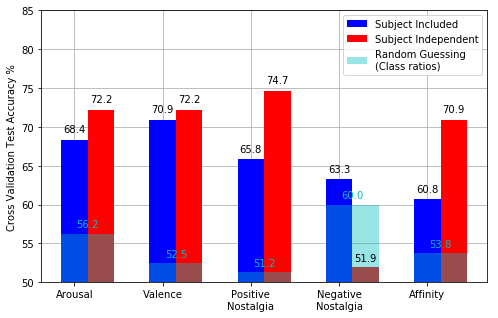

In [309]:
emo_ls = [
    "Arousal",
    "Valence",
    "Positive\nNostalgia",
    "Negative\nNostalgia",
    "Affinity"
]
ax = plt.subplot(111)
fig.clear()
b1 = ax.bar(np.arange(len(emos)), data_dep[:, 0], width=0.3,color='b',align='center', tick_label=emo_ls)
b2 = ax.bar(np.arange(len(emos)) + 0.3, data[:, 0], width=0.3,color='r',align='center')
b3 = ax.bar(np.arange(len(emos))+0.15, np.asarray(max_rand_accs) * 100, width=0.6,alpha=0.4,color='c',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')
# ax.xlabel()
plt.ylim((50, 85))
ax.set_axisbelow(True)
ax.grid()
ax.set_ylabel("Cross Validation Test Accuracy %")
# ax.set_title

ax.legend((b1[0], b2[0], b3[0]), ('Subject Included', 'Subject Independent', 'Random Guessing\n(Class ratios)'))
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        alpha = rect.get_alpha()
        light = False
        if alpha is not None and alpha < 1.0:
            light = True
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                str(round(height, 1)),
                ha='center', va='bottom', color='c' if light else 'black')

autolabel(b1)
autolabel(b2)
autolabel(b3)

fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.savefig(graphics_dir + "/" + "binary_results.pdf", filetype='pdf')
plt.show()

[0.5625, 0.525, 0.5125, 0.6, 0.5375]

In [300]:
type(max_rand_accs)

list

In [310]:
Y_split_vals

array([1.56744504, 2.62030605, 4.84595611, 2.4699913 , 7.52326683])

In [5]:
# Feature importances
emos = [
    "Arousal",
    "Valence",
    "Positive Nostalgia",
    "Negative Nostalgia",
    "Affinity"
]
fade_in_buffers = [0, 0, 0, 0, 0]
feature_is = [       # SUBJECT INDEPENDENT                                                  # test val acc
    [363, 124, 27, 491, 493, 457, 495, 461, 304, 489, 356, 483, 91, 332, 92, 368, 431, 90], # 81.25 71.43
    [27, 77, 1, 477, 43, 168, 42, 249, 152, 97, 98, 2, 229, 73, 110, 15, 414, 13, 47, 65],  # 73.016 93.75
    [337, 447, 252, 314, 223, 448, 80, 275, 440, 48, 102, 347, 346, 12, 446, 445, 16, 108, 222, 345], # 77.78 87.5
    [381, 49, 287, 420, 440, 283, 225, 51, 98, 52, 409, 359, 60, 412, 58, 0, 59, 50], # 66.667 37.5
    [175, 41, 9, 14, 43, 105, 13, 46, 78, 112, 400, 83, 79, 77, 51, 75, 47, 432], # 73.016 68.75
]
n_emos = len(emos)
n_samples = 8
r = {}
emo_is = [emo_labels_all.index(x) for x in emos]
feat_accuracies = []
for i in range(len(emos)):
    all_feat_is, emo = feature_is[i], emos[i]
    # Get full feature set accuracy
    X_d = X_data
    X_d = [[x_[:,all_feat_is] for x_ in x] for x in X_data]
    data_tup = X_d, Y_data_r, Y_data_c, Y_split_vals, "SVC", "SVR"
    res=Parallel(n_jobs=n_cpu)(delayed(test_model)(data_tup, subj_dep, [emo],
        fade_in_buffer=fade_in_buffers[i], select=False, validate=False) for j in range(n_samples))
    train_accs, test_accs, val_accs = [np.mean(accs, axis=0) for accs in zip(*res) if isinstance(accs[0], np.ndarray)]
    best_acc = test_accs[0]
    print("Best acc", best_acc)
    
    feat_accs = [best_acc]
    for j in range(len(all_feat_is)):
        feat_is = [all_feat_is[k] for k in range(len(all_feat_is)) if k != j]
        X_d = X_data
        X_d = [[x_[:, feat_is] for x_ in x] for x in X_data]
        data_tup = X_d, Y_data_r, Y_data_c, Y_split_vals, "SVC", "SVR"
        res=Parallel(n_jobs=n_cpu)(delayed(test_model)(data_tup, subj_dep, [emo],
        fade_in_buffer=fade_in_buffers[i], select=False, validate=False) for j in range(n_samples))
        train_accs, test_accs, val_accs = [np.mean(accs, axis=0) for accs in zip(*res) if isinstance(accs[0], np.ndarray)]
        feat_accs.append(test_accs[0])
        print(feat_accs[-1])
    feat_accuracies.append(np.asarray(feat_accs))

Best acc 72.15189873417721
73.41772151898735
74.68354430379746
72.15189873417721
70.88607594936708
72.15189873417721
70.88607594936708
72.15189873417721
72.15189873417721
74.68354430379746
70.88607594936708
73.41772151898735
72.15189873417721
70.88607594936708
73.41772151898735
70.88607594936708
73.41772151898735
72.15189873417721
70.88607594936708
Best acc 70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
68.35443037974683
70.88607594936708
72.15189873417721
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
72.15189873417721
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
70.88607594936708
Best acc 73.41772151898735
73.41772151898735
73.41772151898735
69.62025316455697
74.68354430379746
72.15189873417721
73.41772151898735
73.41772151898735
70.88607594936708
73.41772151898735
73.41772151898735
74.68354430379746
73.41772151898735
73.41772151898735
7

In [33]:
for i in range(len(emos)):
    emo = emos[i]
    feat_is = feature_is[i]
    feat_accs = feat_accuracies[i]
    best_acc = feat_accs[0]
    rest_accs = feat_accs[1:]
    feat_loss = best_acc - rest_accs
    ranking = sorted([[feat_loss[j], X_labels[feat_is[j]]] for j in range(len(feat_is))])
    ranking = ranking[:10]
    pr(ranking)
#     ranking = ranking[::-1]
#     losses, labels = zip(*ranking)
#     losses = -np.asarray(losses)
#     print(losses)
#     plt.barh(range(len(labels)), losses )
#     ax = plt.gca()
#     ax.set_ylabels(range(5))
#     plt.show()

[   [-2.5316455696202524, 'subjectBaseline_EDA_win4_np_2nd_deriv'],
    [-2.5316455696202524, 'subjectBaseline_HR_win2_amin'],
    [-1.2658227848101404, 'globalSongBaseline_HR_win4_amax'],
    [-1.2658227848101404, 'subjectBaseline_HR_win3_amax'],
    [-1.2658227848101404, 'subjectBaseline_HR_win4_amin'],
    [-1.2658227848101404, 'subjectBaseline_HR_win4_mean'],
    [0.0, 'globalSongBaseline_EDA_win1_np_2nd_deriv'],
    [0.0, 'globalSongBaseline_TEMP_win2_amin'],
    [0.0, 'globalSongBaseline_TEMP_win4_amin'],
    [0.0, 'globalSongBaseline_TEMP_win4_mean']]
[   [-1.2658227848101262, 'pureSignal_BVP_win4_std'],
    [-1.2658227848101262, 'subjectBaseline_BVP_win2_std'],
    [0.0, 'globalBaseline_EDA_win1_mean'],
    [0.0, 'globalBaseline_EDA_win2_amax'],
    [0.0, 'globalBaseline_EDA_win4_amin'],
    [0.0, 'globalBaseline_EDA_win4_mean'],
    [0.0, 'globalBaseline_TEMP_win1_fl_delta'],
    [0.0, 'globalSongBaseline_EDA_win1_amin'],
    [0.0, 'globalSongBaseline_EDA_win1_np_2nd_deriv'],
